In [1]:
#The following code is from Andrew Ng Deeplearning AI
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
import math
import h5py
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

Using TensorFlow backend.
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Hp\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Future

In [2]:
#This Code is from Andrew Ng Kt.utils

def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

def load_dataset():
    train_dataset = h5py.File('datasets/train_happy.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # your train set features
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # your train set labels

    test_dataset = h5py.File('datasets/test_happy.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # your test set features
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # your test set labels

    classes = np.array(test_dataset["list_classes"][:]) # the list of classes
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


The following example is from Andrew Ng Course
```python
def model(input_shape):
    """
    input_shape: The height, width and channels as a tuple.  
        Note that this does not include the 'batch' as a dimension.
        If you have a batch like 'X_train', 
        then you can provide the input_shape using
        X_train.shape[1:]
    """
    
    # Define the input placeholder as a tensor with shape input_shape. Think of this as your input image!
    X_input = Input(input_shape)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((3, 3))(X_input)

    # CONV -> BN -> RELU Block applied to X
    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X)

    # MAXPOOL
    X = MaxPooling2D((2, 2), name='max_pool')(X)

    # FLATTEN X (means convert it to a vector) + FULLYCONNECTED
    X = Flatten()(X)
    X = Dense(1, activation='sigmoid', name='fc')(X)

    # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
    model = Model(inputs = X_input, outputs = X, name='HappyModel')
    
    return model
```

The double parentheses mean that they are actually an object. For example:
```python
X = ZeroPadding2D((3,3))(X_input)
```

is equivalent to this:
```python
ZeroPaddingObject = ZeroPadding2D((3,3)) #This one makes an object of zero padding 2d through constructor
X = ZeroPaddingObject(X_input) #This will call the __call__ function defined inside ZeroPadding2D class
```

Pay attention also that in Keras, we usually overwrite the same variable again and again (except the first one for the xInput / X_input), rather than in TensorFlow where we create different name for each operation. By using the same variable again and again, it signalizes that the layers are stacked.

In [4]:
#This is for practice of Andrew Ng Convolutional Neural Network course week 2 of Keras Toutorial
def HappyModel(inputShape):
    """Make a keras model for the happy problem
    
    Arguments:
    inputShape = the shape of the input (not included with datasets amount, just (nH,nW,nC) as a tuple)
                to discard the dataset amount, use X_train.shape[1:]
                
    Return:
    model = a Model() instance in Keras"""
    
    XInput = Input(inputShape)
    
    X = ZeroPadding2D((3,3))(XInput) #This make a padding in amount of nH, nW. So it pads each height and weight with 3
    
    #Making a convolution layer. Conv2D is used to create a convolution layer for 2d objects such as image
    #Even though the image itself will be broken into volume (RGB for example), Conv2D will understand it as a volume
    #On the other hand, Conv3D is used when there is time variable affects the x dataset
    #32 means the output filter, so the result nC of the convolution will be 32
    #(7,7) means it will create a filter size with 7,7 size.
    #Strides = a tuple of two ints for the amount of stride in nH and nW
    #name = save a name inside the Keras memory
    X = Conv2D(32,(7,7),strides = (1,1), name = 'conv0')(X)
    
    #Normalize the data with the BatchNormalization. Since we want to normalize the number based on the mean of
    #every channel (we make sure that for every channel, the number should be between 0 and 1 and its standard
    #deviation is 0). That is why, we make sure that we normalize it for every channel.
    #Basically, choose the axis that represents the channel, since we have form of (datasets, height, width, channel)
    #We use the axis = 3 since channel is in the fourth shape
    X = BatchNormalization(axis = 3, name = "bn0")(X)
    
    #After we normalize based on the mean and standard deviation of each respective channel, now it is time for us to
    #Do activation layer of relu
    X = Activation('relu')(X)
    
    #After activation, do pooling = MaxPooling2D. We use 2D since the input doesn't take time as argument
    #No need to put the output nC since the number of nC will be the same as the input
    #The tuple means for the size of the filter, in size of (nH, nW)
    X = MaxPooling2D((2,2), name = "maxPool")(X)
    
    #The next layer is used for flattening the resulted X, preparing it for fully connected layer
    #If the input is in shape of (m,nH,nW,nC), it will become (m, nH*nW*nC) after flattened
    X = Flatten()(X)
    
    #Make the final fully connected layer by making a Dense Layer in Keras
    #The 1 means the result node that we want, the activation for the final activation
    X = Dense(1, activation = "sigmoid", name = "fc")(X)
    
    #Now that since everyting is already in set, we can create the model directly by using Model()
    #Set the "inputs = " parameters of the model with the "XInput" Tensor
    #Set the "outputs = " parameters of the model with the "X" Tensor
    model = Model(inputs = XInput, outputs = X, name = "HappyModel")
    
    return model

This explanation is from Andrew Ng Course. 
To train and test this model, there are four steps in Keras:
1. Create the model by calling the function above  
2. Compile the model by calling `model.compile(optimizer = "...", loss = "...", metrics = ["accuracy"])`  
3. Train the model on train data by calling `model.fit(x = ..., y = ..., epochs = ..., batch_size = ...)`  
4. Test the model on test data by calling `model.evaluate(x = ..., y = ...)`  

Refer to the official [Keras documentation](https://keras.io/models/model/).

optimizer = 'adam', 'sgd'

loss = 'binary_crossentropy', 'categorical_crossentropy' (should separate array for each category)

Calling .fit() multiple times will make the model retrain rather thn reinitializing them

In [5]:
#Create model
model = HappyModel(X_train.shape[1:])
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])
model.fit(x = X_train, y = Y_train, epochs = 40, batch_size = 128)
preds = model.evaluate(x=X_test, y = Y_test)
print(f"Loss result = {preds[0]}")
print(f"Test Accuracy = {preds[1]}")


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/40
600/600 [==============================] - 6s 10ms/step - loss: 3.5136 - accuracy: 0.5483
Epoch 2/40
600/600 [==============================] - 5s 9ms/step - loss: 2.5500 - accuracy: 0.5650
Epoch 3/40
600/600 [==============================] - 6s 9ms/step - loss: 1.1623 - accuracy: 0.6083
Epoch 4/40
600/600 [==============================] - 6s 10ms/step - loss: 0.5651 - accuracy: 0.8033
Epoch 5/40
600/600 [==============================] - 7s 12ms/step - loss: 0.4107 - accuracy: 0.8133
Epoch 6/40
600/600 [==============================] - 8s 13ms/step - loss: 0.3683 - accuracy: 0.8400
Epoch 7/40
600/600 [==============================] - 7s 12ms/step - loss: 0.2407 - accuracy: 0.9083
Epoch 8/40
600/600 [==============================] - 8s 13ms/step - loss: 0.1671 - accuracy: 0.9317
Epoch 9/40
600/600 [==============================] - 8s 13ms/step - loss: 0.1560 - accuracy: 0.94

Tips to increase accuracy:
- Use blocks of Conv->BatchNorm->ReLU so that the height and the width can shrink, while the number of channels quite large
- Use MAXPOOL after suc block, it will help us lower the dimension in height and width
- For memory issues, lower the batch_size (to 12 perhaps)
- Run more epochs until te train accuracy no longer improves

[[1.]]


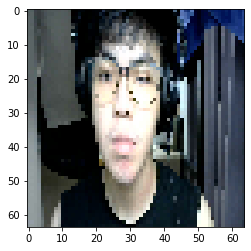

In [6]:
imagePath = "images/NotSmile.jpg"
img = image.load_img(imagePath,target_size = (64,64)) #from keras.preprocessing
imshow(img)

x = image.img_to_array(img) #convert to numpy array
x = np.expand_dims(x,axis = 0) #added one more dimension for the x on index 0
x = preprocess_input(x) #from keras.applications.imagenet_utils (preprocess the input with imagenet rules)

print(model.predict(x))

In [7]:
model.summary()

Model: "HappyModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 70, 70, 3)         0         
_________________________________________________________________
conv0 (Conv2D)               (None, 64, 64, 32)        4736      
_________________________________________________________________
bn0 (BatchNormalization)     (None, 64, 64, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 64, 64, 32)        0         
_________________________________________________________________
maxPool (MaxPooling2D)       (None, 32, 32, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 32768)             0

In [8]:
plot_model(model, to_file = "HappyModel.png")
SVG(model_to_dot(model).create(prog='dot', format='svg'))

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.